In [12]:
import numpy as np
import gzip
import os

# 指定本地文件路径
data_dir = "..\\assets\\MNIST\\raw"
filenames = ['train-images-idx3-ubyte.gz', 'train-labels-idx1-ubyte.gz',
             't10k-images-idx3-ubyte.gz', 't10k-labels-idx1-ubyte.gz']
data = []

for filename in filenames:
    filepath = os.path.join(data_dir, filename)
    print("Loading", filepath)
    with gzip.open(filepath, 'rb') as f:
        if 'labels' in filename:
            # 读取标签数据，偏移量为8字节
            data.append(np.frombuffer(f.read(), np.uint8, offset=8))
        else:
            # 读取图像数据，偏移量为16字节，并转换为 (num_samples, 28*28)
            data.append(np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28))

# 分割训练和测试数据
X_train, y_train, X_test, y_test = data

# 归一化像素值到 [0,1] 之间
X_train = X_train.astype(np.float32) / 255.0
X_test = X_test.astype(np.float32) / 255.0

# 转换标签为整数类型
y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

print("Data loaded successfully!")

Loading ..\assets\MNIST\raw\train-images-idx3-ubyte.gz
Loading ..\assets\MNIST\raw\train-labels-idx1-ubyte.gz
Loading ..\assets\MNIST\raw\t10k-images-idx3-ubyte.gz
Loading ..\assets\MNIST\raw\t10k-labels-idx1-ubyte.gz
Data loaded successfully!


In [13]:
print("X_train:", X_train.shape)

X_train: (60000, 784)


In [14]:
import matplotlib.pyplot as plt
def show_images(images, labels):
    """
    Display a set of images and their labels using matplotlib.
    The first column of `images` should contain the image indices,
    and the second column should contain the flattened image pixels
    reshaped into 28x28 arrays.
    """
    # Extract the image indices and reshaped pixels
    pixels = images.reshape(-1, 28, 28)

    # Create a figure with subplots for each image
    fig, axs = plt.subplots(
        ncols=len(images), nrows=1, figsize=(10, 3 * len(images))
    )

    # Loop over the images and display them with their labels
    for i in range(len(images)):
        # Display the image and its label
        axs[i].imshow(pixels[i], cmap="gray")
        axs[i].set_title("Label: {}".format(labels[i]))

        # Remove the tick marks and axis labels
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_xlabel("Index: {}".format(i))

    # Adjust the spacing between subplots
    fig.subplots_adjust(hspace=0.5)

    # Show the figure
    plt.show()

In [15]:
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

In [16]:
# 手写数字分类模型
class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)
        

    def forward(self, x):
        Z1 = F.relu(self.fc1(x))
        A1 = torch.sigmoid(Z1)
        Z2 = self.fc2(A1)
        # A2 = F.softmax(Z2, dim=1)
        return Z2

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
X_train = torch.from_numpy(X_train).to(device)
y_train = torch.from_numpy(y_train).to(device)
num_epochs = 10
batch_size = 64
# Create a DataLoader to handle batching of the training data
train_data = torch.utils.data.TensorDataset(X_train, y_train)
train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=batch_size, shuffle=True
)


Using device: cuda


In [18]:
model = MLP().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.CrossEntropyLoss()


In [19]:
# training loop
for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    # Print the epoch loss
    epoch_loss = total_loss / len(train_loader.dataset)
    print(
        "Epoch {}/{}: loss={:.4f}".format(epoch + 1, num_epochs, epoch_loss)
    )
    

Epoch 1/10: loss=0.0175
Epoch 2/10: loss=0.0064
Epoch 3/10: loss=0.0050
Epoch 4/10: loss=0.0044
Epoch 5/10: loss=0.0040
Epoch 6/10: loss=0.0036
Epoch 7/10: loss=0.0034
Epoch 8/10: loss=0.0032
Epoch 9/10: loss=0.0030
Epoch 10/10: loss=0.0028


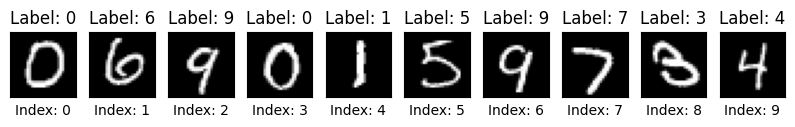

In [22]:
# 可视化模型预测结果
model.eval()
# X_test = torch.from_numpy(X_test).to(device)
# y_test = torch.from_numpy(y_test).to(device)
y_pred = model(torch.from_numpy(X_test).to(device))
y_pred = torch.argmax(y_pred, dim=1)
show_images(X_test[10:20], y_pred.cpu().numpy()[10:20])



In [23]:
torch.save(model.state_dict(), "mlp_mnist.pth")